<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/6_Scratch_Oversampling_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Sat Jun 20 16:07:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Librries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_6classes_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 6

LR = 3e-5 # Learning rate

# Data

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/6_classes_HAM10000_split

Cloning into '6_classes_HAM10000_split'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3355 (delta 5), reused 0 (delta 0), pack-reused 3343
Receiving objects: 100% (3355/3355), 881.25 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (3315/3315), done.


In [6]:
train_path = '/content/6_classes_HAM10000_split/train/' 
val_path = '/content/6_classes_HAM10000_split/val/'
test_path = '/content/6_classes_HAM10000_split/test/'

## Data Augmentaion

In [7]:
class_list = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

for item in class_list:

    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir(train_path + img_class)

    for fname in img_list:
        # source path to image
        src = os.path.join(train_path + img_class, fname)
        # destination path to image
        dst = os.path.join(img_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = train_path + img_class

    # Create a data generator to augment the images in real time
    datagen = ImageDataGenerator(rotation_range=360,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='reflect')

    batch_size = 32

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 2000  # total number of images we want to have in each class
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 205 images belonging to 1 classes.
Found 323 images belonging to 1 classes.
Found 692 images belonging to 1 classes.
Found 72 images belonging to 1 classes.
Found 700 images belonging to 1 classes.
Found 88 images belonging to 1 classes.


In [8]:
print(len(os.listdir('/content/6_classes_HAM10000_split/train/akiec')))
print(len(os.listdir('/content/6_classes_HAM10000_split/train/bcc')))
print(len(os.listdir('/content/6_classes_HAM10000_split/train/bkl')))
print(len(os.listdir('/content/6_classes_HAM10000_split/train/df')))
print(len(os.listdir('/content/6_classes_HAM10000_split/train/mel')))
print(len(os.listdir('/content/6_classes_HAM10000_split/train/vasc')))

1877
1903
1992
1544
2008
1848


In [9]:
train_aug = ImageDataGenerator(rescale=1./255)

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None) 

Found 11172 images belonging to 6 classes.
Found 896 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


# Model

## Build

In [11]:
def build_model():
  base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  # for layer in base_model.layers:
  #   if isinstance(layer, BatchNormalization):
  #     layer.trainable = True
  #   else:
  #     layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  # fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  # fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  # fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  # bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  # dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=6, activation='softmax', name='prediction')(average_pooling_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  return model

In [12]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Compile

In [14]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='6_scratch_over_vgg16_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [16]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
350/350 [==============================] - 85s 242ms/step - loss: 1.0928 - accuracy: 0.5727 - val_loss: 0.9041 - val_accuracy: 0.6362 - lr: 3.0000e-05
Epoch 2/100
350/350 [==============================] - 84s 240ms/step - loss: 0.6365 - accuracy: 0.7532 - val_loss: 0.8008 - val_accuracy: 0.6998 - lr: 3.0000e-05
Epoch 3/100
350/350 [==============================] - 84s 240ms/step - loss: 0.4759 - accuracy: 0.8190 - val_loss: 0.8174 - val_accuracy: 0.6964 - lr: 3.0000e-05
Epoch 4/100
350/350 [==============================] - 84s 240ms/step - loss: 0.3612 - accuracy: 0.8635 - val_loss: 0.7742 - val_accuracy: 0.7522 - lr: 3.0000e-05
Epoch 5/100
350/350 [==============================] - 84s 239ms/step - loss: 0.2742 - accuracy: 0.8972 - val_loss: 0.9139 - val_accuracy: 0.7143 - lr: 3.0000e-05
Epoch 6/100
350/350 [==============================] - 84s 240ms/step - loss: 0.2352 - accuracy: 0.9148 - val_loss: 0.8613 - val_accuracy: 0.7188 - lr: 3.0000e-05
Epoch 7/100
350/350 [=

# Graph

## Accuracy

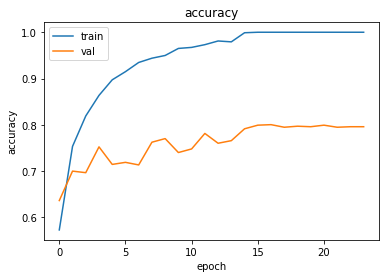

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

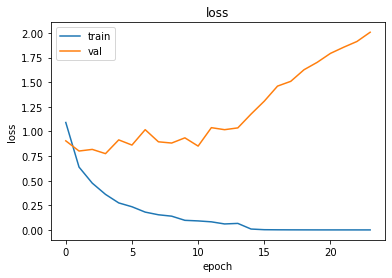

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [19]:
test_model = tf.keras.models.load_model('/content/6_scratch_over_vgg16_model.h5')

In [20]:
num_test_files = len(test_generator.filenames)

In [21]:
test_generator.reset()

In [22]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[18  5  5  1  4  0]
 [ 1 40  6  1  4  0]
 [ 0  4 84  0 22  0]
 [ 1  0  1  9  1  0]
 [ 1  2 16  1 92  0]
 [ 0  1  1  0  0 13]]


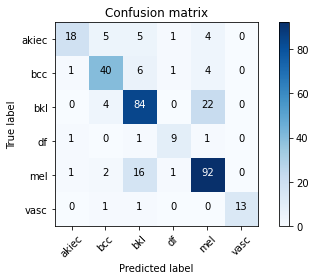

In [24]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.54545455 0.15151515 0.15151515 0.03030303 0.12121212 0.        ]
 [0.01923077 0.76923077 0.11538462 0.01923077 0.07692308 0.        ]
 [0.         0.03636364 0.76363636 0.         0.2        0.        ]
 [0.08333333 0.         0.08333333 0.75       0.08333333 0.        ]
 [0.00892857 0.01785714 0.14285714 0.00892857 0.82142857 0.        ]
 [0.         0.06666667 0.06666667 0.         0.         0.86666667]]


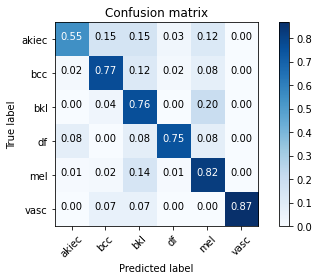

In [25]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [26]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[18  5  5  1  4  0]
 [ 1 40  6  1  4  0]
 [ 0  4 84  0 22  0]
 [ 1  0  1  9  1  0]
 [ 1  2 16  1 92  0]
 [ 0  1  1  0  0 13]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.86      0.55      0.67        33
         bcc       0.77      0.77      0.77        52
         bkl       0.74      0.76      0.75       110
          df       0.75      0.75      0.75        12
         mel       0.75      0.82      0.78       112
        vasc       1.00      0.87      0.93        15

    accuracy                           0.77       334
   macro avg       0.81      0.75      0.78       334
weighted avg       0.77      0.77      0.76       334



# Model Analysis

In [28]:
MD = (abs(0.78-0.67) + abs(0.78-0.77) + abs(0.78-0.75) + abs(0.78-0.75) + abs(0.78-0.78) + abs(0.78-0.93)) / 6

## Low

In [29]:
0.78 - MD

0.725

## High

In [30]:
0.78 + MD

0.8350000000000001

# Grad-CAM

In [31]:
last_conv2d = 'block5_conv3'

## AKIEC

In [41]:
akiec_img = '/content/6_classes_HAM10000_split/train/akiec/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 1.000
	bkl            	(2)	with probability 0.000
	akiec          	(0)	with probability 0.000
	bcc            	(1)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


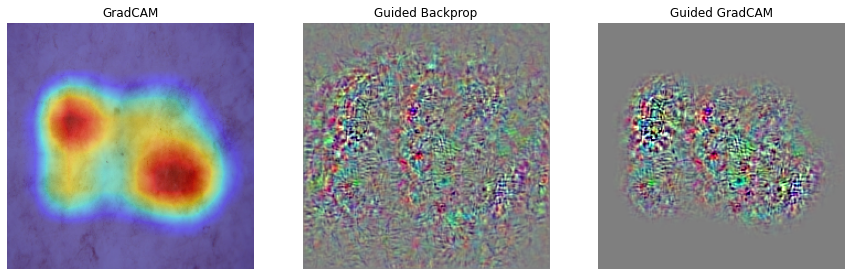

In [43]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

## BCC

In [44]:
bcc_img = '/content/6_classes_HAM10000_split/train/bcc/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.963
	bcc            	(1)	with probability 0.027
	akiec          	(0)	with probability 0.009
	bkl            	(2)	with probability 0.002
	df             	(3)	with probability 0.000
Explanation for 'mel'


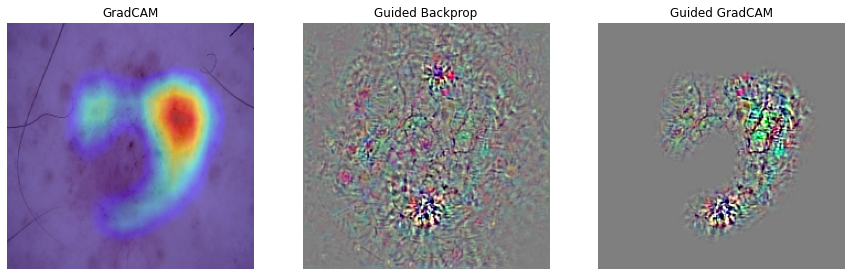

In [45]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

## BKL

In [50]:
bkl_img = '/content/6_classes_HAM10000_split/train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.997
	bkl            	(2)	with probability 0.003
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


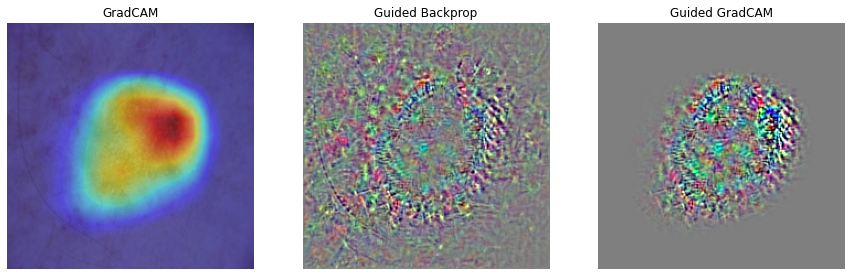

In [51]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

## DF

In [54]:
df_img = '/content/6_classes_HAM10000_split/val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.996
	df             	(3)	with probability 0.002
	bkl            	(2)	with probability 0.002
	akiec          	(0)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


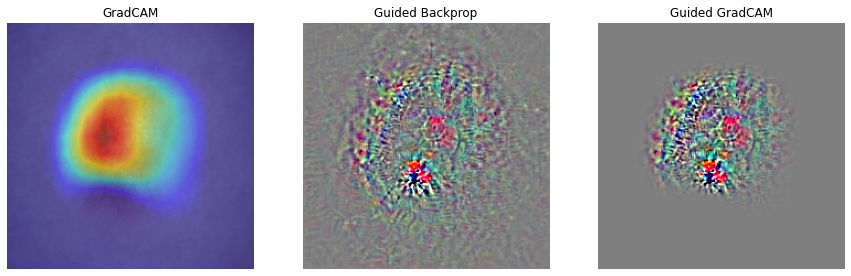

In [55]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

## MEL

In [57]:
mel_img = '/content/6_classes_HAM10000_split/train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 1.000
	bkl            	(2)	with probability 0.000
	akiec          	(0)	with probability 0.000
	bcc            	(1)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


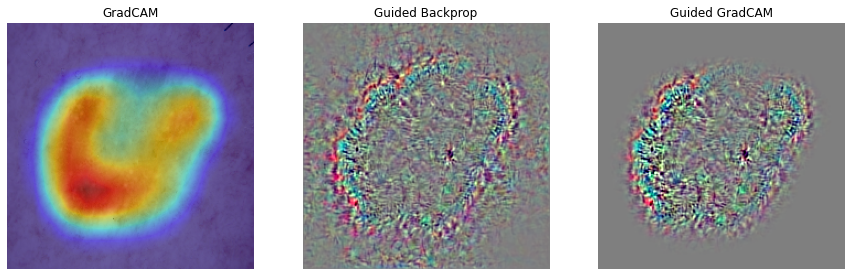

In [58]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

## VASC

In [67]:
vasc_img = '/content/6_classes_HAM10000_split/test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(5)	with probability 1.000
	mel            	(4)	with probability 0.000
	bkl            	(2)	with probability 0.000
	df             	(3)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'vasc'


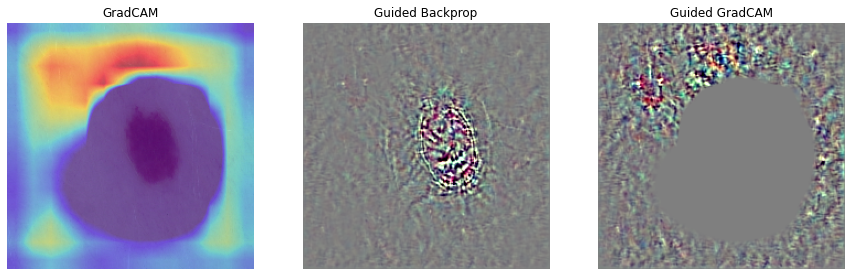

In [68]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)